### Instalación de librerías

In [59]:
from IPython import display
%pip install gensim
%pip install nltk
%pip install matplotlib
%pip install scikit-learn
display.clear_output()

### Imports

In [60]:
import nltk
import matplotlib.pyplot as plt

from typing import List
from pathlib import Path
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from nltk.tokenize import sent_tokenize
from gensim.utils import simple_preprocess

In [61]:
nltk.download('punkt_tab', download_dir='./nltk_data')
nltk.data.path.append('./nltk_data')

[nltk_data] Downloading package punkt_tab to ./nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


### Preprocesamiento del corpus

Las siguientes funciones se encargan de preparar los textos de los siete libros de Harry Potter para el entrenamiento de modelos de embeddings con Word2Vec.

El procesamiento de la función process_books_for_word2vec() sigue los siguientes pasos:

1. Lectura de los libros: 
   Se leen todos los archivos .txt ubicados en la carpeta hp/. Cada archivo representa un libro completo.

2. Segmentación en oraciones:  
   Se utiliza la función sent_tokenize() de la librería nltk para dividir cada texto en oraciones.

3. Tokenización de oraciones:  
   Cada oración se tokeniza mediante simple_preprocess de Gensim, que:
   - Convierte todas las palabras a minúsculas,
   - Elimina signos de puntuación,
   - Elimina acentos (deacc=True).

El resultado final es una lista de listas de tokens (oraciones tokenizadas) que puede utilizarse directamente como entrada para entrenar modelos de embeddings con gensim.models.Word2Vec.

In [62]:
def read_all_books(directory: Path) -> List[str]:
    """
    Lee todos los archivos .txt dentro del directorio especificado.

    :param directory: Ruta a la carpeta con los archivos de texto.
    :return: Lista de strings, uno por cada libro completo.
    """
    all_text = []
    for book_file in sorted(directory.glob("*.txt")):
        with open(book_file, 'r', encoding='utf-8') as f:
            text = f.read()
            all_text.append(text)
    return all_text

def split_into_sentences(text: str) -> List[str]:
    """
    Divide un texto en oraciones usando la segmentación de NLTK.

    :param text: Texto unificado.
    :return: Lista de oraciones.
    """
    return sent_tokenize(text)

def tokenize_sentences(sentences: List[str]) -> List[List[str]]:
    """
    Tokeniza cada oración en palabras, eliminando puntuación y pasando a minúsculas.

    :param sentences: Lista de oraciones.
    :return: Lista de listas de palabras (tokens).
    """
    return [simple_preprocess(sentence, deacc=True) for sentence in sentences]

def process_books_for_word2vec(directory: Path) -> List[List[str]]:
    """
    Procesa todos los libros en un directorio para generar oraciones tokenizadas
    aptas para entrenamiento con Word2Vec.

    :param directory: Ruta a la carpeta con los libros.
    :return: Lista de oraciones tokenizadas.
    """
    raw_books = read_all_books(directory)
    all_sentences = []
    for book in raw_books:
        sentences = split_into_sentences(book)
        tokenized = tokenize_sentences(sentences)
        all_sentences.extend(tokenized)
    return all_sentences

def get_word_vectors(model: Word2Vec, words: List[str]) -> List[List[float]]:
    """
    Extrae los vectores de palabras del modelo Word2Vec.

    :param model: Modelo Word2Vec entrenado.
    :param words: Lista de palabras a visualizar.
    :return: Lista de vectores correspondientes a las palabras.
    """
    return [model.wv[word] for word in words if word in model.wv]

def reduce_vectors_pca(vectors: List[List[float]], n_components: int = 3) -> List[List[float]]:
    """
    Reduce la dimensionalidad de los vectores usando PCA.

    :param vectors: Lista de vectores originales.
    :param n_components: Número de componentes PCA a conservar.
    :return: Vectores transformados a menor dimensión.
    """
    pca = PCA(n_components=n_components)
    return pca.fit_transform(vectors)

def plot_3d_words(words: List[str], reduced_vectors: List[List[float]]) -> None:
    """
    Grafica los vectores de palabras reducidos en 3D con anotaciones.

    :param words: Lista de palabras.
    :param reduced_vectors: Vectores 3D correspondientes.
    """
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    xs, ys, zs = zip(*reduced_vectors)

    ax.scatter(xs, ys, zs, color='skyblue', s=50)

    for word, x, y, z in zip(words, xs, ys, zs):
        ax.text(x, y, z, word, fontsize=9)

    ax.set_title("Proyección 3D de embeddings con PCA")
    plt.show()

def visualize_embeddings_3d(model: Word2Vec, words: List[str]) -> None:
    """
    Flujo completo para obtener, reducir y graficar vectores de palabras.

    :param model: Modelo Word2Vec entrenado.
    :param words: Lista de palabras a visualizar.
    """
    vectors = get_word_vectors(model, words)
    reduced = reduce_vectors_pca(vectors)
    plot_3d_words(words, reduced)

In [63]:
BOOKS_DIR = Path("hp")

sentences = process_books_for_word2vec(BOOKS_DIR)

print(f"Total de oraciones (docs): {len(sentences)}")

Total de oraciones (docs): 66129


### Entrenamiento del modelo Word2Vec

In [64]:
if Path("hp_word2vec.model").exists():
    w2v_model = Word2Vec.load("hp_word2vec.model")
    print("Modelo cargado desde 'hp_word2vec.model'.")
else:
    print(
        "El archivo 'hp_word2vec.model' no existe. Se entrena y posteriormente "
        "guarda el modelo."
    )
    w2v_model = Word2Vec(
        sentences=sentences,        # Lista de oraciones tokenizadas
        vector_size=100,            # Dimensión de los vectores
        window=5,                   # Contexto de palabras (5 a la izquierda y 5 a la derecha)
        min_count=5,                # Palabras con frecuencia < 5 son ignoradas
        workers=4,                  # Número de hilos de procesamiento paralelo
        sg=1,                       # Skip-gram (1) en lugar de CBOW (0)
        epochs=10                   # Número de pasadas completas sobre el corpus
    )
    w2v_model.save("hp_word2vec.model")

Modelo cargado desde 'hp_word2vec.model'.


In [65]:
print(f"Cantidad de words distintas en el corpus: {len(w2v_model.wv.index_to_key)}")

Cantidad de words distintas en el corpus: 8945


### Pruebas

#### Similitud semántica

Se realiza una exploración del espacio de embeddings entrenado con Word2Vec usando el método:

```python
w2v_model.wv.most_similar('palabra_objetivo')
```

Este devuelve las palabras que tienen mayor similitud coseno con el vector asociado a la palabra dada. Es decir, aquellas que aparecen en contextos similares y, por lo tanto, tienen un significado o función similar dentro del corpus.

In [66]:
w2v_model.wv.most_similar('voldemort')

[('lord', 0.6861612796783447),
 ('wormtail', 0.6722836494445801),
 ('existed', 0.6607217192649841),
 ('nagini', 0.646398663520813),
 ('dumbledores', 0.6296890377998352),
 ('weakness', 0.6190014481544495),
 ('quirrell', 0.6127578020095825),
 ('dumbledore', 0.6066954731941223),
 ('immortality', 0.6058774590492249),
 ('gregorovitch', 0.6045021414756775)]

In [67]:
w2v_model.wv.most_similar('gryffindor')

[('ravenclaw', 0.7492218017578125),
 ('slytherin', 0.7464183568954468),
 ('tower', 0.7013822197914124),
 ('points', 0.6744107007980347),
 ('hufflepuff', 0.6610947251319885),
 ('possession', 0.6421495079994202),
 ('goalposts', 0.635903000831604),
 ('chaser', 0.6338302493095398),
 ('championship', 0.6316118240356445),
 ('captain', 0.6067246794700623)]

In [68]:
w2v_model.wv.most_similar('quidditch')

[('match', 0.7592418193817139),
 ('team', 0.7158492207527161),
 ('season', 0.7112775444984436),
 ('seeker', 0.6902853846549988),
 ('performance', 0.6629675030708313),
 ('supplies', 0.653921365737915),
 ('session', 0.6528952121734619),
 ('cup', 0.6450088024139404),
 ('practice', 0.6439194083213806),
 ('tryouts', 0.6433351039886475)]

In [69]:
w2v_model.wv.most_similar('hermione')

[('parvati', 0.6295778155326843),
 ('lavender', 0.6274082660675049),
 ('ron', 0.6222432851791382),
 ('ginny', 0.620416522026062),
 ('luna', 0.6087537407875061),
 ('encouragingly', 0.6078932285308838),
 ('grabbing', 0.6073558926582336),
 ('incredulously', 0.5881399512290955),
 ('perplexed', 0.587963879108429),
 ('uh', 0.5838364362716675)]

Puede observarse que los resultados anteriores muestran que el modelo capturó correctamente relaciones semánticas relevantes:

- Por ejemplo, voldemort aparece junto a wormtail y nagini, personajes fuertemente ligados a él en la historia.

- gryffindor se asocia con otras casas como ravenclaw y slytherin, reflejando la estructura del colegio.

- quidditch muestra proximidad con términos como match y seeker, indicando que el modelo entendió bien el contexto del deporte.

#### Detección de outlier semánticos 

Se detectan palabras "intrusas" utilizando el método:

```python
w2v_model.wv.doesnt_match(lista_de_palabras)
```

Este sirve para detectar cuál de las palabras no encaja semánticamente con el resto. Internamente, Word2Vec calcula el vector promedio de todas las palabras y devuelve aquella cuyo vector está más alejado del centroide de los demás.

In [70]:
w2v_model.wv.doesnt_match(['harry', 'ron', 'hermione', 'voldemort'])

'voldemort'

In [71]:
w2v_model.wv.doesnt_match(['malfoy', 'riddle', 'lestrange', 'weasley'])

'weasley'

Los resultados obtenidos con doesnt_match() muestran que el modelo logra identificar correctamente qué palabra no encaja semánticamente en un grupo:

- En el primer ejemplo, 'voldemort' es detectado como intruso frente a 'harry', 'ron' y 'hermione', que conforman el trío protagonista, mientras que Voldemort es su antagonista.

- En el segundo ejemplo, 'weasley' es separado del grupo formado por 'malfoy', 'riddle' y 'lestrange', todos personajes ligados a los villanos, lo que refleja una clara separación semántica entre "bandos" en el corpus.

#### Semántica relacional mediante analogías

Una de las capacidades más interesantes de los embeddings entrenados con Word2Vec es su habilidad para capturar relaciones semánticas vectoriales mediante operaciones aritméticas simples. Se utiliza el método:

```python
w2v_model.wv.most_similar(positive=[...], negative=[...])
```

Este permite construir este tipo de analogías mediante sumas y restas de vectores. Internamente, calcula:

$$
\text{resultado} = \sum \text{(positivos)} - \sum \text{(negativos)}
$$

y devuelve las palabras más similares al vector resultante, usando cosine similarity.

In [72]:
w2v_model.wv.most_similar(positive=["ron", "goyle"], negative=["harry"])

[('crabbe', 0.7852412462234497),
 ('pansy', 0.5699352025985718),
 ('guffawed', 0.5448824763298035),
 ('parkinson', 0.5382308959960938),
 ('zabini', 0.5377624034881592),
 ('gregory', 0.49223610758781433),
 ('cronies', 0.4894270598888397),
 ('george', 0.4674016535282135),
 ('neighbours', 0.46551889181137085),
 ('malfoy', 0.4628375768661499)]

En esta prueba se buscó resolver la analogía “Ron es a Harry como ¿quién es a Goyle?”

El modelo devolvió como primer resultado a 'crabbe', lo cual es coherente con el universo narrativo: así como Ron es el compañero cercano de Harry, Crabbe cumple un rol equivalente respecto de Goyle. Esto sugiere que el modelo capturó correctamente relaciones de co-ocurrencia y agrupaciones de personajes consistentes dentro del corpus.

### Visualización del espacio de embeddings con PCA

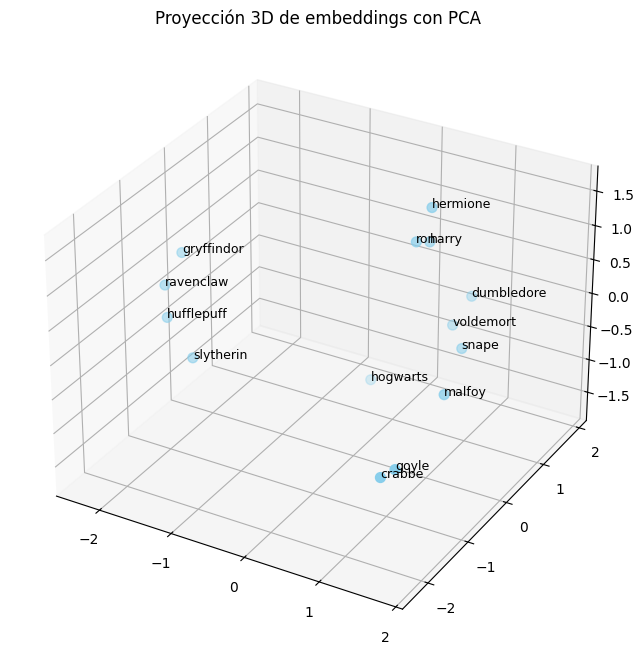

In [73]:
selected_words = [
    'harry',
    'ron',
    'hermione',
    'dumbledore',
    'voldemort',
    'snape',
    'malfoy',
    'crabbe',
    'goyle',
    'hogwarts',
    'gryffindor',
    'slytherin',
    'hufflepuff',
    'ravenclaw',
]

visualize_embeddings_3d(w2v_model, selected_words)

La proyección 3D mediante PCA muestra una distribución coherente con la estructura narrativa de los libros:

- Hermione, Ron y Harry aparecen agrupados, reflejando su frecuente co-ocurrencia.

- Dumbledore se ubica cercano a ellos, pero también como nexo con el grupo de antagonistas.

- Voldemort, Snape, Malfoy, Crabbe y Goyle forman un segundo grupo claramente diferenciado, siendo Crabbe y Goyle los más cercanos entre sí ya que rara vez se los ve separados.

- Las cuatro casas de Hogwarts (gryffindor, slytherin, ravenclaw, hufflepuff) también aparecen próximas entre sí, con hogwarts ocupando una posición central, lo que refleja su rol como espacio común que une a todas.

### Conclusión final

En este trabajo se entrenó un modelo Word2Vec utilizando como corpus los siete libros de Harry Potter. El texto fue procesado para obtener una lista de oraciones tokenizadas, que luego se utilizó como entrada para el entrenamiento del modelo.

Luego se realizaron pruebas de similitud semántica, analogías y detección de palabras fuera de contexto. También se visualizó el espacio de embeddings proyectado en 3D mediante PCA, lo que permitió observar agrupamientos coherentes entre personajes, casas y conceptos clave del universo de Harry Potter.

Los resultados obtenidos fueron muy buenos: el modelo logró reflejar relaciones semánticas esperables dentro del corpus, agrupando personajes aliados, separando bandos opuestos y posicionando adecuadamente elementos estructurales como las casas de Hogwarts.

Finalmente, se puede concluir que, con un corpus bien segmentado y una configuración básica de Word2Vec, es posible obtener representaciones vectoriales útiles para explorar estructuras semánticas emergentes.